In [1]:
from mimic3benchmark.readers import InHospitalMortalityReader
from mimic3models import common_utils
from mimic3models.metrics import print_metrics_binary
from mimic3models.in_hospital_mortality.utils import save_results
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
import pandas as pd
import re
import numpy as np # Import numpy for np.nan
from sklearn.preprocessing import LabelEncoder
import os
import json
import pandas as pd
import argparse
from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, precision_recall_curve, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

/scratch/hht9zt/conda-envs/tf1_env/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
df = pd.read_csv('readmission/test/10026_episode1_timeseries.csv')
df.columns

Index(['Hours', 'Capillary refill rate', 'Diastolic blood pressure',
       'Fraction inspired oxygen', 'Glascow coma scale eye opening',
       'Glascow coma scale motor response', 'Glascow coma scale total',
       'Glascow coma scale verbal response', 'Glucose', 'Heart Rate', 'Height',
       'Mean blood pressure', 'Oxygen saturation', 'Respiratory rate',
       'Systolic blood pressure', 'Temperature', 'Weight', 'pH'],
      dtype='object')

In [3]:
df = pd.read_csv('in-hospital-mortality/test/listfile.csv')

In [4]:
sum(df['y_true'])/len(df['y_true'])*100

11.557478368355994

In [5]:
def read_and_extract_features(reader, period, features):
    ret = common_utils.read_chunk(reader, reader.get_number_of_examples())
    X = common_utils.extract_features_from_rawdata(ret['X'], ret['header'], period, features)
    return (X, ret['y'], ret['name'])


def load_extra_feature(path):
    df = pd.read_csv(path)
    df = preprocessing_extra_features(df)
    return df.values.astype(np.float32)



In [17]:
class Args:
    C = 10.0
    l1 = 0
    l2 = True
    period = 'all'
    features = 'all'
    data = 'in-hospital-mortality/'
    output_dir = '.'

args = Args()
target_repl = False

### Demographic Info add

<!-- ### Demographic Information -->

In [7]:
def preprocessing_extra_features(df):

    df['subject_id'] = df['stay'].apply(lambda x: int(re.match(r'(\d+)_episode(\d+)_timeseries\.csv', x).group(1)))
    df['episode'] = df['stay'].apply(lambda x: int(re.match(r'(\d+)_episode(\d+)_timeseries\.csv', x).group(2)))

    # Load MIMIC-III tables
    # Ensure these paths are correct and the files are accessible.
    patients = pd.read_csv('/scratch/hht9zt/mimic-iii-clinical-database-1.4/physionet.org/files/mimiciii/1.4/PATIENTS.csv')
    admissions = pd.read_csv('/scratch/hht9zt/mimic-iii-clinical-database-1.4/physionet.org/files/mimiciii/1.4/ADMISSIONS.csv')
    icustays = pd.read_csv('/scratch/hht9zt/mimic-iii-clinical-database-1.4/physionet.org/files/mimiciii/1.4/ICUSTAYS.csv')



    df = df.merge(patients[['SUBJECT_ID', 'GENDER', 'DOB']], left_on='subject_id', right_on='SUBJECT_ID', how='left')

    icustays_sorted = icustays.sort_values(by=['SUBJECT_ID', 'INTIME'])
    icustays_sorted['episode'] = icustays_sorted.groupby('SUBJECT_ID').cumcount() + 1


    df = df.merge(icustays_sorted[['SUBJECT_ID', 'ICUSTAY_ID', 'HADM_ID', 'INTIME', 'episode']],
                  on=['SUBJECT_ID', 'episode'], how='left')

    # --- Age Calculation Fix ---
    # # Ensure ADMITTIME and DOB are datetime objects
    admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
    patients['DOB'] = pd.to_datetime(patients['DOB'])

    # # Merge DOB into the admissions DataFrame
    admissions = admissions.merge(patients[['SUBJECT_ID', 'DOB']], on='SUBJECT_ID', how='left')

    df = df.merge(admissions[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ETHNICITY','ADMISSION_TYPE','ADMISSION_LOCATION', 'INSURANCE','LANGUAGE','RELIGION']],
                  on=['SUBJECT_ID', 'HADM_ID'], how='left')
    df.drop(columns=['stay', 'y_true','subject_id', 'episode', 'SUBJECT_ID', 'DOB', 'ICUSTAY_ID', 'HADM_ID', 'INTIME', 'ADMITTIME'], inplace=True)


    categorical_cols = [
        'GENDER',
        'ETHNICITY',
        'ADMISSION_TYPE',
        'ADMISSION_LOCATION',
        'INSURANCE',
        'LANGUAGE',
        'RELIGION'
    ]

    # Initialize a dict to keep label encoders in case you want to inverse transform later
    label_encoders = {}

    for col in categorical_cols:
        le = LabelEncoder()
        # Fill missing values with a placeholder string to avoid errors
        df[col] = df[col].fillna('UNKNOWN')
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    
    print(df.columns)

    return df


### Diagnosis, procedure, drug info added, comorbidities

In [8]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# --- Helper Functions ---
def has_icd_prefix(icd_list, prefix_list):
    if not isinstance(icd_list, list):
        return 0
    for code in icd_list:
        for prefix in prefix_list:
            if str(code).startswith(str(prefix)):
                return 1
    return 0

def one_hot_prefix_old(df, col_name, prefix_len=2, new_col_prefix='', top_n=None):
    df[col_name] = df[col_name].fillna('').apply(lambda x: set(str(x).split('|')) if isinstance(x, str) else set(x))
    df[f'{col_name}_prefixes'] = df[col_name].apply(lambda x: set([item[:prefix_len] for item in x if item]))
    all_prefixes = [prefix for row in df[f'{col_name}_prefixes'] for prefix in row]
    prefix_counts = Counter(all_prefixes)
    selected_prefixes = set([p for p, _ in prefix_counts.most_common(top_n)]) if top_n else set(prefix_counts.keys())
    for prefix in sorted(selected_prefixes):
        new_col = f"{new_col_prefix}_{prefix}"
        df[new_col] = df[f'{col_name}_prefixes'].apply(lambda x: int(prefix in x))
    df.drop(columns=[col_name, f'{col_name}_prefixes'], inplace=True)
    return df

def one_hot_prefix(df, col_name, prefix_len=2, new_col_prefix='', top_n=None):
    df[col_name] = df[col_name].fillna('').apply(
        lambda x: list(str(x).split('|')) if isinstance(x, str) else list(x)
    )

    df[f'{col_name}_prefixes'] = df[col_name].apply(
        lambda x: [item[:prefix_len] for item in x if item]
    )
    all_prefixes = [prefix for row in df[f'{col_name}_prefixes'] for prefix in row]
    prefix_counts = Counter(all_prefixes)
    selected_prefixes = set([p for p, _ in prefix_counts.most_common(top_n)]) if top_n else set(prefix_counts.keys())
    for prefix in sorted(selected_prefixes):
        binary_col = f"{new_col_prefix}_{prefix}"
        count_col = f"{binary_col}_aggr"

        # df[binary_col] = df[f'{col_name}_prefixes'].apply(lambda x: int(prefix in x))
        df[count_col] = df[f'{col_name}_prefixes'].apply(lambda x: x.count(prefix))

    df.drop(columns=[col_name, f'{col_name}_prefixes'], inplace=True)
    return df


# --- ICD Code Categories ---
explicitsepsis = ['99591', '99592', '78552', '038']
infection = ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '020', '021', '022', '023', '024', '025', '026', '027', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '052', '053', '054', '055', '056', '057', '058', '060', '061', '062', '063', '064', '065', '066', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '090', '091', '092', '093', '094', '095', '096', '097', '098', '100', '101', '102', '103', '104', '110', '111', '112', '114', '115', '116', '117', '118', '120', '121', '122', '123', '124', '125', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139']
organdysfunction = ['584', '7855', '570', '572', '51881', '51882', '51885', '51886', '7991', '293', '3483']
diabetes = ['250']
cardiovascular = ['390', '391', '392', '393', '394', '395', '396', '397', '398', '401', '402', '403', '404', '405', '410', '411', '412', '413', '414', '415', '416', '417', '420', '421', '422', '423', '424', '425', '426', '427', '428', '429']
cancer = ['140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189']
lung = ['490', '491', '492', '493', '494', '495', '496', '500', '501', '502', '503', '504', '505']
dementia = ['290', '294']
kidney_dialysis = ['585']
liver = ['570', '571', '572']
immune_system = ['279']

# --- Load Data ---
def icd_add(df):
    
    df['SUBJECT_ID'] = df['stay'].apply(lambda x: int(re.match(r'(\d+)_episode(\d+)_timeseries\.csv', x).group(1)))
    df['episode'] = df['stay'].apply(lambda x: int(re.match(r'(\d+)_episode(\d+)_timeseries\.csv', x).group(2)))

    mimic_path = '/scratch/hht9zt/mimic-iii-clinical-database-1.4/physionet.org/files/mimiciii/1.4/'
    patients = pd.read_csv(f'{mimic_path}PATIENTS.csv')
    admissions = pd.read_csv(f'{mimic_path}ADMISSIONS.csv')
    icustays = pd.read_csv(f'{mimic_path}ICUSTAYS.csv')
    procedures = pd.read_csv(f'{mimic_path}PROCEDURES_ICD.csv')
    prescriptions = pd.read_csv(f'{mimic_path}PRESCRIPTIONS.csv')
    diagnoses = pd.read_csv(f'{mimic_path}DIAGNOSES_ICD.csv')

    # --- ICU Stays ---
    icustays_sorted = icustays.sort_values(by=['SUBJECT_ID', 'INTIME'])
    icustays_sorted['episode'] = icustays_sorted.groupby('SUBJECT_ID').cumcount() + 1
    df = df.merge(icustays_sorted[['SUBJECT_ID', 'ICUSTAY_ID', 'HADM_ID', 'INTIME', 'episode']],
                  on=['SUBJECT_ID', 'episode'], how='left')

    # --- Demographics ---
    admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'], errors='coerce')
    patients['DOB'] = pd.to_datetime(patients['DOB'], errors='coerce')
    admissions_demog = admissions.merge(patients[['SUBJECT_ID', 'GENDER', 'DOB']], on='SUBJECT_ID', how='left')
    admissions_demog['age'] = admissions_demog['ADMITTIME'].dt.year - admissions_demog['DOB'].dt.year
    admissions_demog.loc[admissions_demog['age'] < 0, 'age'] = np.nan
    admissions_demog.loc[admissions_demog['age'] > 150, 'age'] = np.nan

    df = df.merge(admissions_demog[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'age', 'ETHNICITY',
                                     'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'INSURANCE',
                                     'LANGUAGE', 'RELIGION', 'GENDER', 'DOB']],
                  on=['SUBJECT_ID', 'HADM_ID'], how='left')

    # --- Procedures (as string set) ---
    proc_agg = procedures.groupby('HADM_ID')['ICD9_CODE'] \
        .apply(lambda x: list(set(x.dropna().astype(str)))) \
        .reset_index(name='ICD_PROCEDURES')
    df = df.merge(proc_agg, on='HADM_ID', how='left')

    # --- Prescriptions (as list of drug names) ---
    drug_agg = prescriptions.groupby('HADM_ID')['DRUG'] \
        .apply(lambda x: list(set(x.dropna().str.upper()))) \
        .reset_index(name='DRUGS')
    df = df.merge(drug_agg, on='HADM_ID', how='left')

    # --- Diagnoses (as list) ---
    diag_agg = diagnoses.groupby('HADM_ID')['ICD9_CODE'] \
        .apply(lambda x: list(set(x.dropna().astype(str)))) \
        .reset_index(name='diag_codes')
    df = df.merge(diag_agg, on='HADM_ID', how='left')

    # --- Comorbidity Flags ---
    df['explicit_sepsis'] = df['diag_codes'].apply(lambda codes: has_icd_prefix(codes, explicitsepsis))
    df['infection'] = df['diag_codes'].apply(lambda codes: has_icd_prefix(codes, infection))
    df['organ_dysfunction'] = df['diag_codes'].apply(lambda codes: has_icd_prefix(codes, organdysfunction))
    df['diabetes'] = df['diag_codes'].apply(lambda codes: has_icd_prefix(codes, diabetes))
    df['cardiovascular'] = df['diag_codes'].apply(lambda codes: has_icd_prefix(codes, cardiovascular))
    df['cancer'] = df['diag_codes'].apply(lambda codes: has_icd_prefix(codes, cancer))
    df['lung_disease'] = df['diag_codes'].apply(lambda codes: has_icd_prefix(codes, lung))
    df['dementia'] = df['diag_codes'].apply(lambda codes: has_icd_prefix(codes, dementia))
    df['kidney_dialysis'] = df['diag_codes'].apply(lambda codes: has_icd_prefix(codes, kidney_dialysis))
    df['liver_disease'] = df['diag_codes'].apply(lambda codes: has_icd_prefix(codes, liver))
    df['immune_disorder'] = df['diag_codes'].apply(lambda codes: has_icd_prefix(codes, immune_system))

    # --- One-hot prefix encoding ---
    df = one_hot_prefix(df, 'ICD_PROCEDURES', prefix_len=2, new_col_prefix='proc', top_n=50)
    df = one_hot_prefix(df, 'DRUGS', prefix_len=2, new_col_prefix='drug', top_n=50)
    df = one_hot_prefix(df, 'diag_codes', prefix_len=2, new_col_prefix='diag', top_n=50)

    # --- Encode Categorical ---
    # categorical_cols = [
    #     'GENDER', 'ETHNICITY', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
    #     'INSURANCE', 'LANGUAGE', 'RELIGION'
    # ]
    # label_encoders = {}
    # for col in categorical_cols:
    #     df[col] = df[col].fillna('UNKNOWN')
    #     le = LabelEncoder()
    #     df[col] = le.fit_transform(df[col])
    #     label_encoders[col] = le
    #     print(f"Encoded '{col}': {len(le.classes_)} categories.")

    # --- Final Cleanup ---
    columns_to_drop = ['SUBJECT_ID','stay', 'episode', 'ICUSTAY_ID', 'HADM_ID', 'INTIME', 'ADMITTIME', 'DOB', 'subject_id', 'GENDER', 'ETHNICITY', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
        'INSURANCE', 'LANGUAGE', 'RELIGION', 'age', 'y_true']
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

    # --- Final Output ---
    print("\n--- Final DataFrame Columns ---")
    print(df.columns.tolist())
    print(f"Final shape: {df.shape}")
    print("\nSample rows:")
    print(df.head())
    return df


### Loading Vitals, hourly data + imputation

In [6]:
# Hardcoded paths to the prediction files
# Readers
train_reader = InHospitalMortalityReader(dataset_dir=os.path.join(args.data, 'train'),
                                         listfile='listfile.csv',
                                         period_length=48.0)
val_reader = InHospitalMortalityReader(dataset_dir=os.path.join(args.data, 'train'),
                                       listfile= 'listfile.csv',
                                       period_length=48.0)
test_reader = InHospitalMortalityReader(dataset_dir=os.path.join(args.data, 'test'),
                                        listfile='listfile.csv',
                                        period_length=48.0)

print('Reading data and extracting features ...')
(train_X, train_y, train_names) = read_and_extract_features(train_reader, args.period, args.features)
(val_X, val_y, val_names) = read_and_extract_features(val_reader, args.period, args.features)
(test_X, test_y, test_names) = read_and_extract_features(test_reader, args.period, args.features)

print('  train data shape = {}'.format(train_X.shape))
print('  validation data shape = {}'.format(val_X.shape))
print('  test data shape = {}'.format(test_X.shape))


print('Imputing missing values ...')
imputer = SimpleImputer(missing_values=np.nan, strategy='mean', copy=True)
imputer.fit(train_X)
train_X = np.array(imputer.transform(train_X), dtype=np.float32)
val_X = np.array(imputer.transform(val_X), dtype=np.float32)
test_X = np.array(imputer.transform(test_X), dtype=np.float32)

print('Normalizing the data to have zero mean and unit variance ...')
scaler = StandardScaler()
scaler.fit(train_X)
train_X = scaler.transform(train_X)
val_X = scaler.transform(val_X)
test_X = scaler.transform(test_X)



-------------------- in-hospital-mortality/train
-------------------- in-hospital-mortality/train
-------------------- in-hospital-mortality/test
Reading data and extracting features ...
  train data shape = (17903, 714)
  validation data shape = (17903, 714)
  test data shape = (3236, 714)
Imputing missing values ...
Normalizing the data to have zero mean and unit variance ...


In [210]:
sum(test_y)/len(test_y)

0.11557478368355995

### concat feature

In [8]:
extra_feature_file_train = os.path.join('mimic3-benchmarks/in-hospital-mortality/train/', 'listfile.csv')
extra_feature_file_test = os.path.join('mimic3-benchmarks/in-hospital-mortality/test/', 'listfile.csv')

train_extra = load_extra_feature(extra_feature_file_train)
val_extra = load_extra_feature(extra_feature_file_train)  # Using same file for val
test_extra = load_extra_feature(extra_feature_file_test)

train_X = np.concatenate([train_X, train_extra], axis=1)
val_X = np.concatenate([val_X, val_extra], axis=1)
test_X = np.concatenate([test_X, test_extra], axis=1)
# pd.read_csv(extra_feature_file_train).columns
# extra_feature_file_train.columns()

Index(['GENDER', 'ETHNICITY', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'INSURANCE', 'LANGUAGE', 'RELIGION'],
      dtype='object')
Index(['GENDER', 'ETHNICITY', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'INSURANCE', 'LANGUAGE', 'RELIGION'],
      dtype='object')
Index(['GENDER', 'ETHNICITY', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'INSURANCE', 'LANGUAGE', 'RELIGION'],
      dtype='object')


## add icd code

In [185]:
df_extra_icd_train = pd.read_csv('readmission/train/listfile_30_newCarefullyDone.csv')
df_extra_icd_test = pd.read_csv('readmission/test/listfile_30_newCarefullyDone.csv')

train_extra= icd_add(df_extra_icd_train)
test_extra= icd_add(df_extra_icd_test)

train_X = np.concatenate([train_X, train_extra], axis=1)
val_X = np.concatenate([val_X, train_extra], axis=1)
test_X = np.concatenate([test_X, test_extra], axis=1)
# pd.read_csv(extra_feature_file_train).columns
# extra_feature_file_train.columns()

## add embedding of reasoning from unstruct data (finetuned LLM inference)

In [143]:
import pandas as pd
df_main_train = pd.read_csv('readmission/train/listfile_30_newCarefullyDone.csv')
df_main_test = pd.read_csv('readmission/test/listfile_30_newCarefullyDone.csv')


df_extra = pd.read_csv('../finetune/predictions_vs_ground_truth_test_readmission30_notes.csv')
df_extra2 = pd.read_csv('../finetune/predictions_vs_ground_truth_train_readmission30_notes.csv')

df_extra = pd.concat([df_extra, df_extra2], ignore_index=True)



df_extra["stay"] = df_extra["patient_id"].apply(lambda x: f"{x.split('_')[0]}_episode{int(x.split('_')[1]) + 1}_timeseries.csv")
# Tokenize reasoning for Word2Vec
reasoning = df_extra["reasoning"].astype(str)
tokenized_paragraphs = [r.lower().split() for r in reasoning]

# Train Word2Vec model
embedding_size = 100
w2v_model = Word2Vec(sentences=tokenized_paragraphs, vector_size=embedding_size, window=5, min_count=1, workers=4)

# Convert each reasoning to embedding
def paragraph_to_vector(tokens, model, embedding_dim):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(embedding_dim)

vectors = [paragraph_to_vector(tokens, w2v_model, embedding_size) for tokens in tokenized_paragraphs]

# Add prediction and vector to df_extra
df_extra["y_pred"] = df_extra["prediction"]
df_extra["embedding"] = vectors

# Keep only necessary columns

df_extra_reduced = df_extra[["stay", "y_pred", "embedding"]]
df_extra_reduced = df_extra_reduced.drop_duplicates(subset='stay', keep='first')


# Merge with df_main

res1 = df_main_train.merge(df_extra_reduced, on="stay", how="left")
res2 = df_main_test.merge(df_extra_reduced, on="stay", how="left")


embedding_size = 100 

# Fill y_pred NaNs
res1["y_pred"] = res1["y_pred"].fillna(0).astype(int)
res2["y_pred"] = res2["y_pred"].fillna(0).astype(int)

# Fill missing embeddings with zero vectors
res1["embedding"] = res1["embedding"].apply(
    lambda x: x if isinstance(x, np.ndarray) else np.zeros(embedding_size)
)
res2["embedding"] = res2["embedding"].apply(
    lambda x: x if isinstance(x, np.ndarray) else np.zeros(embedding_size)
)

# Convert to numpy arrays
pred_col1 = res1["y_pred"].values.reshape(-1, 1)
emb_matrix1 = np.vstack(res1["embedding"].values)
res1_array = np.hstack((pred_col1, emb_matrix1))

pred_col2 = res2["y_pred"].values.reshape(-1, 1)
emb_matrix2 = np.vstack(res2["embedding"].values)
res2_array = np.hstack((pred_col2,emb_matrix2))

print("res1 shape:", res1_array.shape)
print("res2 shape:", res2_array.shape)


res1 shape: (17903, 101)
res2 shape: (3236, 101)


In [144]:
train_X = np.concatenate([train_X, res1_array], axis=1)
val_X = np.concatenate([train_X, res1_array], axis=1)
test_X = np.concatenate([test_X, res2_array], axis=1)

In [145]:
train_X.shape

(17903, 984)

In [118]:
test_X1.shape, train_X1.shape, val_X.shape, len(train_y), len(test_y), len(val_y)

((3236, 822), (17903, 822), (17903, 822), 17903, 3236, 17903)

### PCA for dimentionality reduction

In [1]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaler.fit(train_X)
train_X = scaler.transform(train_X)
val_X = scaler.transform(val_X)
test_X = scaler.transform(test_X)


print('Reducing dimensionality with PCA ...')
pca = PCA(n_components=0.95, svd_solver='full')  # Keep 95% of variance
pca.fit(train_X)

train_X_ = pca.transform(train_X)
val_X_ = pca.transform(val_X)
test_X_ = pca.transform(test_X)

print('  train shape after PCA:', train_X_.shape)
print('  validation shape after PCA:', val_X_.shape)
print('  test shape after PCA:', test_X_.shape)

# Uncomment and continue training as before
penalty = ('l2' if args.l2 else 'l1')
file_name = '{}.{}.pca.{}.C{}'.format(args.period, args.features, penalty, args.C)

logreg = LogisticRegression(penalty=penalty, C=args.C, random_state=42, max_iter=1000)
logreg.fit(train_X_, train_y)

result_dir = os.path.join(args.output_dir, 'results_combined')
common_utils.create_directory(result_dir)

with open(os.path.join(result_dir, 'train_{}.json'.format(file_name)), 'w') as res_file:
    ret = print_metrics_binary(train_y, logreg.predict_proba(train_X_))
    ret = {k: float(v) for k, v in ret.items()}
    json.dump(ret, res_file)

with open(os.path.join(result_dir, 'val_{}.json'.format(file_name)), 'w') as res_file:
    ret = print_metrics_binary(val_y, logreg.predict_proba(val_X_))
    ret = {k: float(v) for k, v in ret.items()}
    json.dump(ret, res_file)

prediction = logreg.predict_proba(test_X_)[:, 1]
with open(os.path.join(result_dir, 'test_{}.json'.format(file_name)), 'w') as res_file:
    ret = print_metrics_binary(test_y, prediction)
    ret = {k: float(v) for k, v in ret.items()}
    json.dump(ret, res_file)

save_results(test_names, prediction, test_y,
             os.path.join(args.output_dir, 'predictions', file_name + '.csv'))


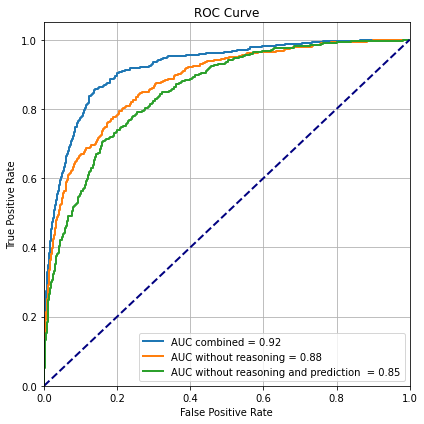

In [137]:
fpr1, tpr1, _ = roc_curve(test_y, prediction_struc)
fpr, tpr, _ = roc_curve(test_y, prediction_unstruc)
fpr2, tpr2, _ = roc_curve(test_y, prediction_w)
fpr3, tpr3, _ = roc_curve(test_y, prediction_unstruc2)
# roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr2, tpr2, lw=2, label=f'AUC combined = {auc(fpr2, tpr2):.2f}')
plt.plot(fpr3, tpr3, lw=2, label=f'AUC without reasoning = {auc(fpr3, tpr3):.2f}')
plt.plot(fpr1, tpr1, lw=2, label=f'AUC without reasoning and prediction  = {auc(fpr1, tpr1):.2f}')
# plt.plot(fpr, tpr, lw=2, label=f'AUC  = {auc(fpr, tpr):.2f}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random guess)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from scipy.stats import pearsonr # For Pearson correlation and p-value

### visualization of features and importance

In [2]:
# np.random.seed(42) # For reproducibility

train_extra = train_X_
n_samples = len(train_extra) # Number of samples (adjust for your data size)
n_features = len(train_extra[0])
np.random.seed(42) # For reproducibility


train_extra = np.array(train_extra)
train_y = np.array(train_y)


print(f"--- Dummy Data Overview ---")
print(f"train_extra shape: {train_extra.shape}")
print(f"train_y shape: {train_y.shape}")
print(f"Class distribution (0s, 1s): {np.bincount(train_y)}")
print("-" * 30)

# # Convert to Pandas DataFrame/Series for easier analysis (especially correlation)
train_extra_df = pd.DataFrame(train_extra, columns=[f'feature_{i}' for i in range(n_features)])
train_y_series = pd.Series(train_y, name='target_class')


# print("\n--- 1. Checking Feature-Target Correlations ---")
# # Interpretation: Low absolute correlation coefficients (e.g., between -0.1 and 0.1)
# # suggest a weak linear relationship between the feature and the target.
# # For non-linear relationships or categorical features, other methods (e.g., mutual information, Chi-squared)
# # would be more appropriate.





correlation_results = []
for col in train_extra_df.columns:
    if pd.api.types.is_numeric_dtype(train_extra_df[col]): # Ensure feature is numeric
        coeff, p_value = pearsonr(train_extra_df[col], train_y_series)
        correlation_results.append({'feature': col, 'correlation': coeff, 'p_value': p_value})
    else:
        # Handle non-numeric features if applicable (e.g., using Cramer's V for categorical)
        pass 

correlations_df = pd.DataFrame(correlation_results).sort_values(by='correlation', ascending=False)

print("\nTop 10 most positively correlated features:")
print(correlations_df.head(10))
print("\nTop 10 most negatively correlated features:")
print(correlations_df.tail(10))
print("\nFeatures with absolute correlation coefficient less than 0.05:")
print(correlations_df[abs(correlations_df['correlation']) < 0.05])


print("\n--- 2. Checking Lack of Clear Visual Separation (using t-SNE) ---")
# t-SNE projects high-dimensional data into 2D/3D for visualization.
# It's sensitive to scaling, so StandardScaler is used first.
# For very large datasets (e.g., >10,000 samples), t-SNE can be slow.
# Consider using UMAP (pip install umap-learn) which is faster and often preserves global structure better,
# or sample a subset of your data for t-SNE visualization.

# Scale the features
scaler = StandardScaler()
train_extra_scaled = scaler.fit_transform(train_extra)

# Limit the number of samples for t-SNE if the dataset is large, for faster computation
n_samples_for_tsne_viz = min(5000, train_extra_scaled.shape[0]) # Adjust as needed
if train_extra_scaled.shape[0] > n_samples_for_tsne_viz:
    # Randomly sample indices for t-SNE to avoid bias
    np.random.seed(42) # For reproducibility of the sample
    sample_indices = np.random.choice(train_extra_scaled.shape[0], n_samples_for_tsne_viz, replace=False)
    X_tsne_sample = train_extra_scaled[sample_indices]
    y_tsne_sample = train_y[sample_indices]
    print(f"  Warning: Using a random subset of {n_samples_for_tsne_viz} samples for t-SNE visualization.")
else:
    X_tsne_sample = train_extra_scaled
    y_tsne_sample = train_y

print(f"  Fitting t-SNE on {X_tsne_sample.shape[0]} samples (may take a moment for large datasets)...")
try:
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000) # Adjust perplexity/n_iter
    X_tsne = tsne.fit_transform(X_tsne_sample)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=X_tsne[:, 0], y=X_tsne[:, 1],
        hue=y_tsne_sample, # Color points by class label
        palette='viridis', # Colormap for the classes
        legend='full',
        alpha=0.7,
        s=50 # Point size
    )
    plt.title('t-SNE Visualization of Feature Space by Target Class')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

except Exception as e:
    print(f"  Could not perform t-SNE visualization. Error: {e}")
    print("  This might be due to very high dimensionality, too few samples for perplexity, or other issues.")
    print("  Consider using PCA for quick visualization or checking data for constancy.")

# Interpretation: If the different colored points (classes) are heavily intermixed without forming distinct clusters,
# it indicates that the current features do not provide clear separability.


print("\n--- 3. Checking Low Feature Importance Scores (using RandomForestClassifier) ---")
# RandomForest is a good choice as it provides feature importances and is robust to scaling.
# Use class_weight='balanced' to account for imbalance when calculating importance.

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
print("  Training RandomForestClassifier for feature importance (this might take a moment)...")
rf_model.fit(train_extra, train_y) # Use original unscaled X here, RF doesn't need scaling
print("  RandomForestClassifier training complete.")

feature_importances = pd.DataFrame({
    'feature': train_extra_df.columns, # Use names from DataFrame
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\nTop 20 most important features:")
print(feature_importances.head(20))

print("\nBottom 20 least important features (potentially uninformative):")
print(feature_importances.tail(20))

# Plotting feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20), palette='viridis')
plt.title('Top 20 Feature Importances from Random Forest')
plt.xlabel('Importance Score (higher is more important)')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# Interpretation: Features with importance scores very close to zero or consistently low suggest they are not
# contributing significantly to the model's decision-making process. If a large number of features fall into this category,
# or even the top features have very small scores, it implies a weak overall signal.

print("\n--- Feature Sufficiency Analysis Complete ---")
print("Consider these indicators together to assess the overall signal in your feature set.")
print("If multiple signs point to insufficient features, focus on feature engineering (creating new features),")
print("gathering more diverse data, or exploring advanced domain-specific data representations.")

### Different ML model Analysis

In [101]:
from sklearn.model_selection import GridSearchCV
# ... (rest of your PCA and data loading) ...

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100], # Range of regularization strengths
    'penalty': ['l1', 'l2'] # Test both L1 and L2 penalties
}

# For L1 penalty, you need a solver that supports it (e.g., 'liblinear', 'saga')
# 'saga' is good for larger datasets and supports L1/L2
# max_iter needs to be very high for 'saga'
logreg_base = LogisticRegression(random_state=42, max_iter=1000000, class_weight='balanced', solver='saga')

grid_search = GridSearchCV(logreg_base, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
# Use 'f1' as scoring since it's good for imbalanced data
# cv=5 for 5-fold cross-validation
# n_jobs=-1 to use all CPU cores

grid_search.fit(train_X_, train_y)

print("\nBest Logistic Regression parameters:", grid_search.best_params_)
print("Best Logistic Regression F1-score (CV):", grid_search.best_score_)

# Use the best estimator found by GridSearchCV
best_logreg = grid_search.best_estimator_

# Now, use best_logreg for prediction and evaluation on val_X_ and test_X_
# ... (rest of your evaluation code with val_probs, test_probs using best_logreg)

In [107]:
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import pandas as pd


rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Apply undersampling to your data (X_train, y_train, not test data)
X_resampled_rus, y_resampled_rus = rus.fit_resample(train_X_, train_y)

print(f"\n--- After Random Undersampling (majority class) ---")
print(f"Resampled dataset shape: X={X_resampled_rus.shape}, y={y_resampled_rus.shape}")
print(f"New class distribution: {np.bincount(y_resampled_rus)}")

# You'll notice that Class 0 now has the same number of samples as Class 1 (100 in this dummy example).
# Be aware: Random undersampling can discard potentially useful information from the majority class.


--- After Random Undersampling (majority class) ---
Resampled dataset shape: X=(2100, 188), y=(2100,)
New class distribution: [1050 1050]


In [237]:
train_features = np.array(train_X)
# val_features = np.array(val_df)
test_features = np.array(test_X)

In [238]:
import seaborn as sns


In [110]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

# val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
# val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


# print('Training labels shape:', train_labels.shape)
# # print('Validation labels shape:', val_labels.shape)
# print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
# print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training features shape: (4114, 824)
Test features shape: (734, 824)


In [177]:
train_X = np.array(train_X)
train_y = np.array(train_y) 


In [142]:
from imblearn.over_sampling import SMOTE


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(train_X_, train_y)

print(sum(train_y), len(train_y))
print(sum(y_resampled), len(y_resampled))

2423 17903
15480 30960


In [178]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, input, target):
        bce_loss = self.bce(input, target)
        probas = torch.sigmoid(input)
        pt = target * probas + (1 - target) * (1 - probas)
        loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        if self.reduction == 'mean':
            return loss.mean()
        return loss.sum()

class DeeperMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.net(x)


Epoch 1/500, Loss: 0.0082
Epoch 2/500, Loss: 0.0061
Epoch 3/500, Loss: 0.0063
Epoch 4/500, Loss: 0.0051
Epoch 5/500, Loss: 0.0049
Epoch 6/500, Loss: 0.0048
Epoch 7/500, Loss: 0.0045
Epoch 8/500, Loss: 0.0046
Epoch 9/500, Loss: 0.0044
Epoch 10/500, Loss: 0.0043
Epoch 11/500, Loss: 0.0043
Epoch 12/500, Loss: 0.0041
Epoch 13/500, Loss: 0.0038
Epoch 14/500, Loss: 0.0036
Epoch 15/500, Loss: 0.0052
Epoch 16/500, Loss: 0.0035
Epoch 17/500, Loss: 0.0033
Epoch 18/500, Loss: 0.0031
Epoch 19/500, Loss: 0.0032
Epoch 20/500, Loss: 0.0029
Epoch 21/500, Loss: 0.0031
Epoch 22/500, Loss: 0.0033
Epoch 23/500, Loss: 0.0032
Epoch 24/500, Loss: 0.0029
Epoch 25/500, Loss: 0.0028
Epoch 26/500, Loss: 0.0026
Epoch 27/500, Loss: 0.0025
Epoch 28/500, Loss: 0.0022
Epoch 29/500, Loss: 0.0022
Epoch 30/500, Loss: 0.0021
Epoch 31/500, Loss: 0.0020
Epoch 32/500, Loss: 0.0022
Epoch 33/500, Loss: 0.0021
Epoch 34/500, Loss: 0.0020
Epoch 35/500, Loss: 0.0019
Epoch 36/500, Loss: 0.0019
Epoch 37/500, Loss: 0.0018
Epoch 38/5

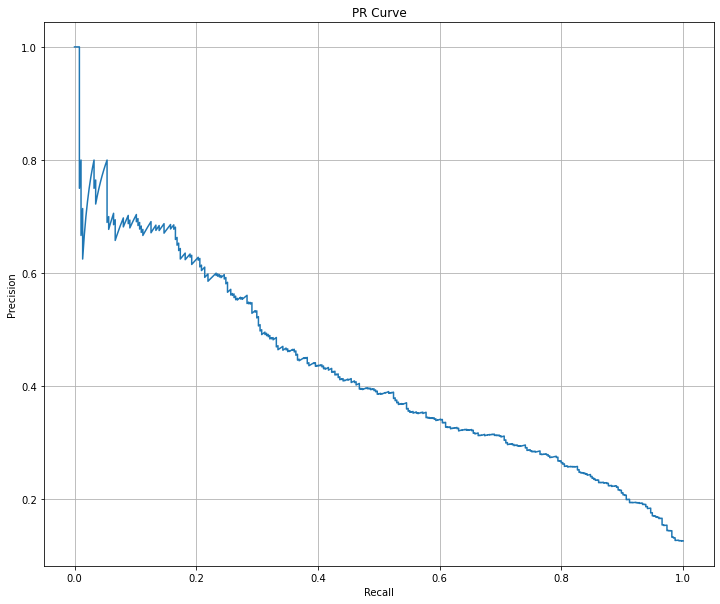

In [203]:


# X_train_, y_train_ = train_X, train_y  # Use raw data (better with pos_weight)

# # X_train_, y_train_ = X_resampled, y_resampled 
# X_test_, y_test_ = test_X, test_y  # Use raw data (better with pos_weight)


# # Tensor conversion
# X_train_ = torch.tensor(X_train_, dtype=torch.float32)
# y_train_ = torch.tensor(y_train_, dtype=torch.float32)
# X_test_ = torch.tensor(X_test_, dtype=torch.float32)
# y_test_ = torch.tensor(y_test_, dtype=torch.float32)

# train_dataset = TensorDataset(X_train_, y_train_)
# test_dataset = TensorDataset(X_test_, y_test_)

# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64)

# # Model
# class MLP(nn.Module):
#     def __init__(self, input_dim, hidden_dim):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, 1)
#         )
#     def forward(self, x):
#         return self.net(x)

# # Loss with pos_weight (handle imbalance properly)
# # pos_weight = torch.tensor([(len(y_train_) - y_train_.sum()) / y_train_.sum()], dtype=torch.float32)
# # criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight*20)

# # model = MLP(input_dim=train_X.shape[1], hidden_dim=128)

# model = DeeperMLP(input_dim=X_train_.shape[1])
# criterion = FocalLoss(alpha=1, gamma=2)
# # pos_weight = torch.tensor([(len(y_train_) - y_train_.sum()) / y_train_.sum()], dtype=torch.float32)
# # print(pos_weight)
# # criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)



# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# # Training loop with early stopping
# epochs = 500
# best_loss = float('inf')
# patience =  10
# patience_counter = 0

# for epoch in range(epochs):
#     model.train()
#     total_loss = 0
#     for xb, yb in train_loader:
#         yb = yb.unsqueeze(1)
#         logits = model(xb)
#         loss = criterion(logits, yb)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
    
#     avg_loss = total_loss / len(train_loader)
#     print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
#     if avg_loss < best_loss:
#         best_loss = avg_loss
#         patience_counter = 0
#         torch.save(model.state_dict(), "best_model.pt")
#     else:
#         patience_counter += 1
#         if patience_counter >= patience:
#             print("Early stopping triggered.")
#             break

# # Load best model
# model.load_state_dict(torch.load("best_model.pt"))
# model.eval()

# # Evaluation
# all_probs = []
# all_labels = []

# with torch.no_grad():
#     for xb, yb in test_loader:
#         logits = model(xb)
#         probs = torch.sigmoid(logits).squeeze().cpu().numpy()
#         all_probs.extend(probs)
#         all_labels.extend(yb.numpy())

# all_probs = np.array(all_probs)
# all_labels = np.array(all_labels)

# # Threshold tuning using precision-recall
# prec, rec, thresholds = precision_recall_curve(all_labels, all_probs)
# minpse = np.minimum(prec, rec)
# best_idx = np.argmax(minpse)
# best_thresh = thresholds[best_idx]
# print(f"Best threshold (max min(+P, Se)): {best_thresh:.4f}, min(+P, Se): {minpse[best_idx]:.4f}")

# # Apply best threshold
# pred_labels = (all_probs > best_thresh).astype(int)

# # Metrics
# print("AUC-ROC:", roc_auc_score(all_labels, all_probs))
# print("AUC-PRC:", average_precision_score(all_labels, all_probs))
# print(classification_report(all_labels, pred_labels))
# print("Confusion Matrix:\n", confusion_matrix(all_labels, pred_labels))

# # Optional plot
# plt.plot(rec, prec)
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.title("PR Curve")
# plt.grid(True)
# plt.show()


Best threshold (max min(+P, Se)): 0.5118, min(+P, Se): 0.9996
AUC-ROC: 0.9999998666952472
AUC-PRC: 0.9999991500998463
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     15480
         1.0       1.00      1.00      1.00      2423

    accuracy                           1.00     17903
   macro avg       1.00      1.00      1.00     17903
weighted avg       1.00      1.00      1.00     17903

Confusion Matrix:
 [[15480     0]
 [    1  2422]]


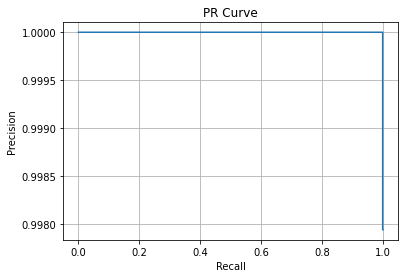

In [157]:
all_probs = []
all_labels = []

with torch.no_grad():
    for xb, yb in train_loader:
        logits = model(xb)
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(yb.numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Threshold tuning using precision-recall
prec, rec, thresholds = precision_recall_curve(all_labels, all_probs)
minpse = np.minimum(prec, rec)
best_idx = np.argmax(minpse)
best_thresh = thresholds[best_idx]
print(f"Best threshold (max min(+P, Se)): {best_thresh:.4f}, min(+P, Se): {minpse[best_idx]:.4f}")

# Apply best threshold
pred_labels = (all_probs > best_thresh).astype(int)

# Metrics
print("AUC-ROC:", roc_auc_score(all_labels, all_probs))
print("AUC-PRC:", average_precision_score(all_labels, all_probs))
print(classification_report(all_labels, pred_labels))
print("Confusion Matrix:\n", confusion_matrix(all_labels, pred_labels))

# Optional plot
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve")
plt.grid(True)
plt.show()

In [187]:
from imblearn.ensemble import BalancedRandomForestClassifier
clf = BalancedRandomForestClassifier(random_state=42)
clf.fit(train_X_, train_y)

BalancedRandomForestClassifier(random_state=42)

In [10]:
# Making predictions on the test set
y_pred = clf.predict(test_X_)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(test_y, y_pred)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Calculate accuracy
accuracy = accuracy_score(test_y, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", confusion_matrix(test_y, y_pred))
print(classification_report(test_y, y_pred))
print("AUC-PRC:", average_precision_score(test_y, y_pred))



In [199]:
from sklearn.model_selection import GridSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier # Make sure this is imported
from sklearn.model_selection import StratifiedKFold

brf = BalancedRandomForestClassifier(random_state=42)
param_grid_brf_refined = {
    'n_estimators': [500, 800, 200],
    'max_features': ['sqrt', 'auto'], # Also try float for max_features
    'max_depth': [15, 8, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    'sampling_strategy': [ 0.8, 0.5, 0.2] 
}

grid_search_brf = GridSearchCV(estimator=BalancedRandomForestClassifier(random_state=42),
                                       param_grid=param_grid_brf_refined, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1, verbose=1)
# grid_search_brf_refined.fit(X_train, y_train)

# grid_search_brf = GridSearchCV(estimator=brf, param_grid=param_grid_brf,
#                                scoring='roc_auc', cv=StratifiedKFold(5), n_jobs=-1, verbose=1)
grid_search_brf.fit(train_X, train_y)

print(f"\nBest parameters for Tuned BRF: {grid_search_brf.best_params_}")
best_brf = grid_search_brf.best_estimator_
y_pred_tuned_brf = best_brf.predict(test_X)
y_proba_tuned_brf = best_brf.predict_proba(test_X)[:, 1]

print(f"Tuned BRF ROC-AUC Score: {roc_auc_score(test_y, y_proba_tuned_brf):.4f}")
report_tuned_brf = classification_report(test_y, y_pred_tuned_brf, output_dict=True)
print(f"Tuned BRF Recall (Minority): {report_tuned_brf['1']['recall']:.4f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best parameters for Tuned BRF: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500, 'sampling_strategy': 0.8}
Tuned BRF ROC-AUC Score: 0.8595
Tuned BRF Recall (Minority): 0.7005


In [268]:
# Build the feature names list based on structure
lab_features = [f"lab_{i}" for i in range(714)]
prediction_feature = ["prediction_unstructured"]
embedding_features = [f"embedding_{i}" for i in range(100)]
categorical_features = [
    "GENDER", "ETHNICITY", "ADMISSION_TYPE",
    "ADMISSION_LOCATION", "INSURANCE", "LANGUAGE", "RELIGION"
]

# Combine all
feature_names = lab_features + categorical_features + prediction_feature + embedding_features

# Sanity check
assert len(feature_names) == train_X.shape[1], "Feature name count doesn't match input dimension"


shap_vals_class1 = shap_values_brf[1]
mean_abs_shap = np.abs(shap_vals_class1).mean(axis=0)

import pandas as pd

shap_importance = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': mean_abs_shap
}).sort_values(by='mean_abs_shap', ascending=False)

top_n = 80
print(shap_importance.head(top_n))


     feature  mean_abs_shap
194  lab_194       0.013070
192  lab_192       0.009309
278  lab_278       0.008843
193  lab_193       0.007908
200  lab_200       0.007219
..       ...            ...
492  lab_492       0.001453
566  lab_566       0.001438
619  lab_619       0.001428
246  lab_246       0.001428
541  lab_541       0.001423

[80 rows x 2 columns]


In [ ]:
len(feature_names), train_X.shape

In [270]:
# Tag each feature with a type
def get_feature_type(name):
    if name.startswith("lab_"):
        return "lab vitals"
    elif name.startswith("embedding_"):
        return "prediction embedding"
    elif name == "prediction_unstructured":
        return "unstructured"
    else:
        return "demographic"

# Add a new column for feature type
shap_importance["type"] = shap_importance["feature"].apply(get_feature_type)

# Group by type and sum mean absolute SHAP values
type_summary = shap_importance.groupby("type")["mean_abs_shap"].sum().reset_index()

# Normalize to percentages (optional)
type_summary["importance_percent"] = 100 * type_summary["mean_abs_shap"] / shap_importance["mean_abs_shap"].sum()

print(type_summary.sort_values(by="importance_percent", ascending=False))


                   type  mean_abs_shap  importance_percent
1            lab vitals       0.444211           89.638958
2  prediction embedding       0.049055            9.899047
0           demographic       0.002276            0.459195
3          unstructured       0.000014            0.002799


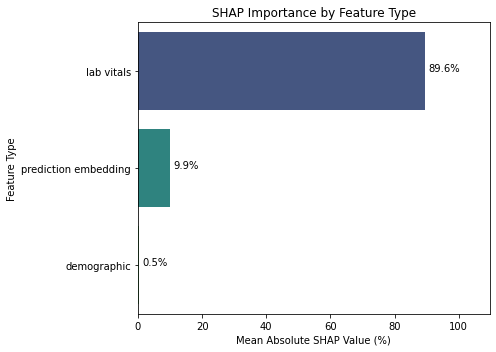

In [271]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort and optionally remove the last row (if needed)
type_summary_sorted = type_summary.sort_values(by="importance_percent", ascending=False)[:-1]

plt.figure(figsize=(7, 5))
ax = sns.barplot(
    x="importance_percent", 
    y="type", 
    data=type_summary_sorted, 
    palette="viridis"
)

# Add value labels to each bar
for i, (value, label) in enumerate(zip(type_summary_sorted["importance_percent"], type_summary_sorted["type"])):
    ax.text(value+1 , i, f"{value:.1f}%", ha='left', fontsize=10)

max_val = type_summary_sorted["importance_percent"].max()
plt.xlim(0, max_val + 20)  # Add extra space on the right

plt.xlabel("Mean Absolute SHAP Value (%)")
plt.ylabel("Feature Type")
plt.title("SHAP Importance by Feature Type")
plt.tight_layout()
plt.show()


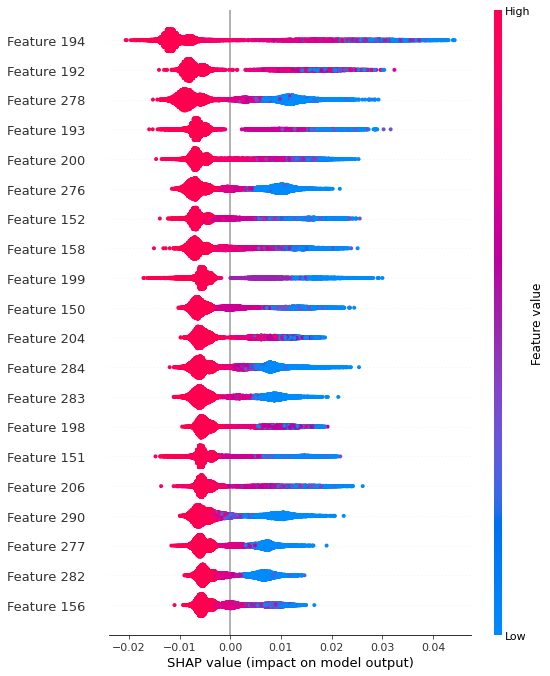

In [267]:
import shap

# Create TreeExplainer for BRF (it’s compatible as BRF uses decision trees)
explainer_brf = shap.TreeExplainer(best_brf)
shap_values_brf = explainer_brf.shap_values(train_X)
shap.summary_plot(shap_values_brf[1], train_X)  # Visualizes importance for the positive class


In [83]:
shap_values_brf[1].shape

(17903, 831)

In [73]:
train_X.shape

(17903, 993)

In [182]:
grid_search_brf.fit(train_X_, train_y)

best_brf = grid_search_brf.best_estimator_
y_pred_tuned_brf = best_brf.predict(test_X_)
y_proba_tuned_brf = best_brf.predict_proba(test_X_)[:, 1]

print(f"Tuned BRF ROC-AUC Score: {roc_auc_score(test_y, y_proba_tuned_brf):.4f}")
report_tuned_brf = classification_report(test_y, y_pred_tuned_brf, output_dict=True)
print(f"Tuned BRF Recall (Minority): {report_tuned_brf['1']['recall']:.4f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Tuned BRF ROC-AUC Score: 0.8610
Tuned BRF Recall (Minority): 0.6016


BalancedRandomForestClassifier[structured, kare output, embedding(reasoning), demographic]-> output
4% positive

In [200]:
print("AUC-ROC:", roc_auc_score(test_y, y_proba_tuned_brf))
print("AUC-PRC:", average_precision_score(test_y, y_proba_tuned_brf))
print(classification_report(test_y, y_pred_tuned_brf))
print("Confusion Matrix:\n", confusion_matrix(test_y, y_pred_tuned_brf))



AUC-ROC: 0.8595172965317249
AUC-PRC: 0.4751512632901119
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      2862
           1       0.34      0.70      0.46       374

    accuracy                           0.81      3236
   macro avg       0.65      0.76      0.67      3236
weighted avg       0.88      0.81      0.83      3236

Confusion Matrix:
 [[2349  513]
 [ 112  262]]


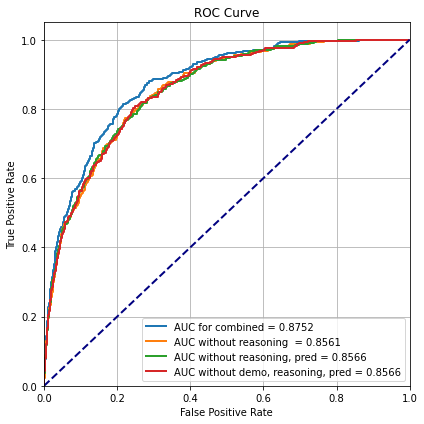

In [182]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, auc

# # Compute ROC curve and AUC
fpr1, tpr1, _ = roc_curve(test_y, y_proba_tuned_brf)
# roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, lw=2, label=f'AUC for combined = {metrics.auc(fpr, tpr):.4f}')
plt.plot(fpr1, tpr1, lw=2, label=f'AUC without reasoning  = {metrics.auc(fpr1, tpr1):.4f}')
plt.plot(fpr2, tpr2, lw=2, label=f'AUC without reasoning, pred = {metrics.auc(fpr2, tpr2):.4f}')
plt.plot(fpr3, tpr3, lw=2, label=f'AUC without demo, reasoning, pred = {metrics.auc(fpr3, tpr3):.4f}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random guess)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


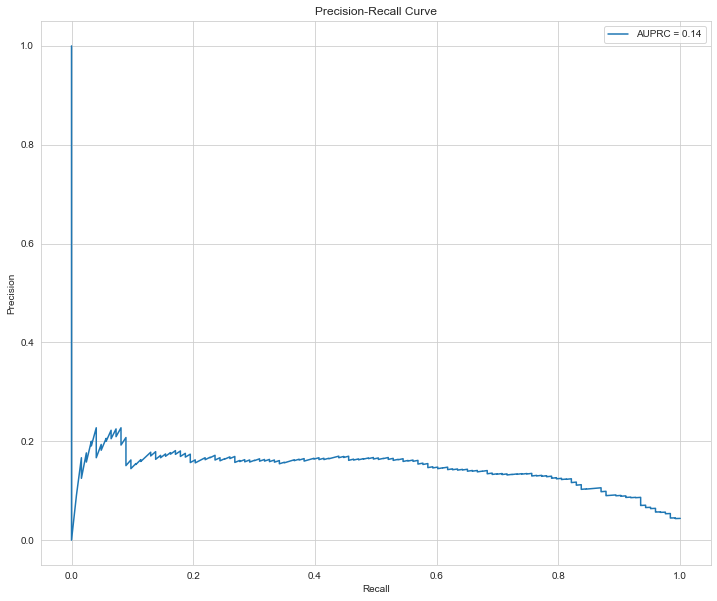

In [137]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
precision, recall, _ = precision_recall_curve(test_y, y_proba_tuned_brf)
plt.plot(recall, precision, label=f'AUPRC = {auc(recall, precision):.2f}')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")  # Suppress convergence warnings


In [30]:
lr = LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')
lr.fit(train_X_, train_y)
lr_proba = lr.predict_proba(test_X_)[:, 1]
lr_pred = (lr_proba >= 0.2).astype(int)

print("\n--- Logistic Regression ---")
print("ROC-AUC:", roc_auc_score(test_y, lr_proba))
print("AUC-PRC:", average_precision_score(test_y, lr_proba))
print(classification_report(test_y, lr_pred))
print("Confusion Matrix:\n", confusion_matrix(test_y, lr_pred))



--- Logistic Regression ---
ROC-AUC: 0.8640698513062554
AUC-PRC: 0.5394651815046315
              precision    recall  f1-score   support

           0       1.00      0.00      0.01      2862
           1       0.12      1.00      0.21       374

    accuracy                           0.12      3236
   macro avg       0.56      0.50      0.11      3236
weighted avg       0.90      0.12      0.03      3236

Confusion Matrix:
 [[   8 2854]
 [   0  374]]


In [202]:
# Calculate imbalance ratio
imbalance_ratio = (np.array(train_y) == 0).sum() *2 / (np.array(train_y) == 1).sum()

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                    scale_pos_weight=imbalance_ratio, random_state=42)
xgb.fit(train_X, train_y)
xgb_proba = xgb.predict_proba(test_X)[:, 1]
xgb_pred = (xgb_proba >= 0.5).astype(int)

print("\n--- XGBoost ---")
print("ROC-AUC:", roc_auc_score(test_y, xgb_proba))
print("AUC-PRC:", average_precision_score(test_y, xgb_proba))
print(classification_report(test_y, xgb_pred))
print("Confusion Matrix:\n", confusion_matrix(test_y, xgb_pred))



--- XGBoost ---
ROC-AUC: 0.8345422407575571
AUC-PRC: 0.48659433327353135
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      2862
           1       0.52      0.38      0.44       374

    accuracy                           0.89      3236
   macro avg       0.72      0.67      0.69      3236
weighted avg       0.88      0.89      0.88      3236

Confusion Matrix:
 [[2733  129]
 [ 232  142]]


In [201]:
lgbm = LGBMClassifier(is_unbalance=True, random_state=42)
lgbm.fit(train_X, train_y)
lgbm_proba = lgbm.predict_proba(test_X)[:, 1]
lgbm_pred = (lgbm_proba >= 0.5).astype(int)

print("\n--- LightGBM ---")
print("ROC-AUC:", roc_auc_score(test_y, lgbm_proba))
print("AUC-PRC:", average_precision_score(test_y, lgbm_proba))
print(classification_report(test_y, lgbm_pred))
print("Confusion Matrix:\n", confusion_matrix(test_y, lgbm_pred))


[LightGBM] [Info] Number of positive: 2423, number of negative: 15480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 96093
[LightGBM] [Info] Number of data points in the train set: 17903, number of used features: 699
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.135340 -> initscore=-1.854542
[LightGBM] [Info] Start training from score -1.854542

--- LightGBM ---
ROC-AUC: 0.8656561919602986
AUC-PRC: 0.5336073214369879
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      2862
           1       0.51      0.48      0.49       374

    accuracy                           0.89      3236
   macro avg       0.72      0.71      0.72      3236
weighted avg       0.88      0.89      0.88      3236

Confusion Matrix:
 [[2688  174]
 [ 194  180]]


In [29]:
# Assuming you have train_X, train_y, test_X, test_y as numpy arrays

from imblearn.over_sampling import SMOTE # Ensure imblearn is installed: pip install imbalanced-learn

# Apply SMOTE only to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(train_X_, train_y)

# Use resampled data for training
X_train_ = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_ = torch.tensor(y_train_resampled, dtype=torch.float32)

# Keep test data as original for realistic evaluation
X_test_ = torch.tensor(test_X_, dtype=torch.float32)
y_test_ = torch.tensor(test_y, dtype=torch.float32)

train_dataset = TensorDataset(X_train_, y_train_)
test_dataset = TensorDataset(X_test_, y_test_)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


# Modify your DeeperMLP to include Dropout
class DeeperMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3), # Add Dropout
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3), # Add Dropout
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

# Rest of your training and evaluation code remains the same.
# Keep FocalLoss with its current settings, or experiment with gamma.

In [166]:
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix,
)
import numpy as np

# Assuming train_X, train_y, test_X, test_y already exist in the environment

# Compute scale_pos_weight
neg = np.sum(np.array(train_y) == 0)
pos = np.sum(np.array(train_y) == 1)
scale_pos_weight = neg / pos

# Train XGBoost model
xgb = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)
xgb.fit(train_X, train_y)

# Predict probabilities
probs = xgb.predict_proba(test_X)[:, 1]

# Threshold tuning
precisions, recalls, thresholds = precision_recall_curve(test_y, probs)
minpse = np.minimum(precisions[:-1], recalls[:-1])
best_idx = np.argmax(minpse)
best_threshold = thresholds[best_idx]
preds = (probs >= best_threshold).astype(int)

# Metrics
report = classification_report(test_y, preds, output_dict=True)
auc_roc = roc_auc_score(test_y, probs)
auc_prc = average_precision_score(test_y, probs)
conf_matrix = confusion_matrix(test_y, preds)

{
    "Best threshold": best_threshold,
    "min(+P, Se)": minpse[best_idx],
    "AUC-ROC": auc_roc,
    "AUC-PRC": auc_prc,
    "Classification Report": report,
    "Confusion Matrix": conf_matrix.tolist()
}



{'Best threshold': 0.18619236,
 'min(+P, Se)': 0.47058823529411764,
 'AUC-ROC': 0.8276185831679728,
 'AUC-PRC': 0.46324612308246976,
 'Classification Report': {'0': {'precision': 0.9308176100628931,
   'recall': 0.9308176100628931,
   'f1-score': 0.9308176100628931,
   'support': 2862},
  '1': {'precision': 0.47058823529411764,
   'recall': 0.47058823529411764,
   'f1-score': 0.47058823529411764,
   'support': 374},
  'accuracy': 0.8776266996291718,
  'macro avg': {'precision': 0.7007029226785053,
   'recall': 0.7007029226785053,
   'f1-score': 0.7007029226785053,
   'support': 3236},
  'weighted avg': {'precision': 0.8776266996291718,
   'recall': 0.8776266996291718,
   'f1-score': 0.8776266996291718,
   'support': 3236}},
 'Confusion Matrix': [[2664, 198], [198, 176]]}

In [58]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
import numpy as np

# Prepare data
X_train = train_X
X_test = test_X
y_test = test_y  # We’ll use this for evaluation

# ------------------------------
# Isolation Forest
# ------------------------------
print("\n--- Isolation Forest ---")
# iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
X_train_clean = train_X[train_y == 0]

iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
iso_forest.fit(X_train_clean)

# iso_forest.fit(X_train)

# Predict: -1 = anomaly, 1 = normal
y_pred_iso = iso_forest.predict(X_test)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)  # Map anomalies to label 1

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_iso))
print("Classification Report:")
print(classification_report(y_test, y_pred_iso))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_iso))
print("AUC-PRC:", average_precision_score(y_test, y_pred_iso))

# ------------------------------
# One-Class SVM
# ------------------------------
print("\n--- One-Class SVM ---")
oc_svm = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')  # Adjust nu depending on anomaly fraction
oc_svm.fit(X_train)

# Predict: -1 = anomaly, 1 = normal
y_pred_svm = oc_svm.predict(X_test)
y_pred_svm = np.where(y_pred_svm == -1, 1, 0)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_svm))
print("AUC-PRC:", average_precision_score(y_test, y_pred_svm))



--- Isolation Forest ---
Confusion Matrix:
[[2621  241]
 [ 250  124]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2862
           1       0.34      0.33      0.34       374

    accuracy                           0.85      3236
   macro avg       0.63      0.62      0.62      3236
weighted avg       0.85      0.85      0.85      3236

AUC-ROC: 0.6236719768906228
AUC-PRC: 0.18989230833730014

--- One-Class SVM ---
Confusion Matrix:
[[1454 1408]
 [ 110  264]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.51      0.66      2862
           1       0.16      0.71      0.26       374

    accuracy                           0.53      3236
   macro avg       0.54      0.61      0.46      3236
weighted avg       0.84      0.53      0.61      3236

AUC-ROC: 0.606959345583097
AUC-PRC: 0.1454476917954743


In [68]:
# These are your inputs
split_point = len(train_y)
outlier_indices = [53, 186, 232, 283, 448, 501, 508, 606, 653, 673, 796, 941, 1034, 1065, 1209, 1271, 1348,
                   1376, 1614, 1656, 1741, 1854, 1904, 1914, 1932, 1945, 2340, 2426, 2590, 2706, 2806, 2961,
                   2988, 3038, 3166, 3175, 3217, 3391, 4043, 4068]

# Split indices
outliers_in_train = [idx for idx in outlier_indices if idx < split_point]
outliers_in_test = [idx - split_point for idx in outlier_indices if idx >= split_point]

# Count how many are label 1
train_anomalies = sum(train_y[i] == 1 for i in outliers_in_train)
test_anomalies = sum(test_y[i] == 1 for i in outliers_in_test)

print(f"Outliers in train set: {len(outliers_in_train)} (True anomalies: {train_anomalies})")
print(f"Outliers in test set: {len(outliers_in_test)} (True anomalies: {test_anomalies})")
print(f"Total detected anomalies (label==1): {train_anomalies + test_anomalies} out of 40")


Outliers in train set: 38 (True anomalies: 6)
Outliers in test set: 2 (True anomalies: 0)
Total detected anomalies (label==1): 6 out of 40


In [240]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np

# Ensure your data is in numpy format
X_train = np.array(train_X_)
y_train = np.array(train_y)
X_val = np.array(val_X_)
y_val = np.array(val_y)
X_test = np.array(test_X_)
y_test = np.array(test_y)

# Define and train the KNN model
k = 5  # You can tune this later
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# Evaluate on validation set
val_preds = knn.predict_proba(X_val)[:, 1]
val_preds_binary = (val_preds > 0.5).astype(int)
val_auc = roc_auc_score(y_val, val_preds)
val_acc = accuracy_score(y_val, val_preds_binary)

# Evaluate on test set
test_preds = knn.predict_proba(X_test)[:, 1]
test_preds_binary = (test_preds > 0.5).astype(int)
test_auc = roc_auc_score(y_test, test_preds)
test_acc = accuracy_score(y_test, test_preds_binary)

print(f"Validation AUC: {val_auc:.4f}, Accuracy: {val_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}, Accuracy: {test_acc:.4f}")


Validation AUC: 0.9491, Accuracy: 0.9627
Test AUC: 0.6611, Accuracy: 0.9567


In [60]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils import resample

# Assuming train_X and train_y are NumPy arrays
# Step 1: Separate majority and minority classes
X_majority = np.array(train_X_)[np.array(train_y)==0]
y_majority = np.array(train_y)[np.array(train_y) == 0]
X_minority = np.array(train_X_)[np.array(train_y) == 1]
y_minority = np.array(train_y)[np.array(train_y) == 1]

# Step 2: Downsample majority class to match minority
X_majority_downsampled, y_majority_downsampled = resample(
    X_majority, y_majority,
    replace=False,
    n_samples=int(len(y_minority)*2),
    random_state=42
)

# Step 3: Concatenate minority and downsampled majority
X_balanced = np.vstack((X_majority_downsampled, X_minority))
y_balanced = np.hstack((y_majority_downsampled, y_minority))

# Step 4: Shuffle the combined dataset
indices = np.random.permutation(len(y_balanced))
X_balanced = X_balanced[indices]
y_balanced = y_balanced[indices]

# Step 5: Convert to PyTorch tensors and create DataLoader
X_tensor = torch.tensor(X_balanced, dtype=torch.float32)
y_tensor = torch.tensor(y_balanced, dtype=torch.float32)

batch_size = 64  # or whatever you used before
train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Now train_loader is ready to be used in training


In [61]:
input_dim = train_X_.shape[1]
hidden_dim = 128
batch_size = 64
epochs = 100
lr = 5e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


val_dataset = TensorDataset(torch.tensor(val_X_, dtype=torch.float32),
                            torch.tensor(val_y, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_X_, dtype=torch.float32),
                             torch.tensor(test_y, dtype=torch.float32))


val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# MLP Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = MLP(input_dim, hidden_dim).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training Loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
def evaluate(loader):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy().flatten()
            preds.extend(pred)
            labels.extend(yb.numpy())
    auc = roc_auc_score(labels, preds)
    acc = accuracy_score(labels, [1 if p > 0.5 else 0 for p in preds])
    return auc, acc, preds

val_auc, val_acc, _ = evaluate(val_loader)
test_auc, test_acc, test_preds = evaluate(test_loader)

print(f"Validation AUC: {val_auc:.4f}, Accuracy: {val_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}, Accuracy: {test_acc:.4f}")


Epoch 1, Loss: 0.3918
Epoch 2, Loss: 0.3157
Epoch 3, Loss: 0.2813
Epoch 4, Loss: 0.2640
Epoch 5, Loss: 0.2373
Epoch 6, Loss: 0.2122
Epoch 7, Loss: 0.1979
Epoch 8, Loss: 0.1762
Epoch 9, Loss: 0.1614
Epoch 10, Loss: 0.1465
Epoch 11, Loss: 0.1409
Epoch 12, Loss: 0.1181
Epoch 13, Loss: 0.1313
Epoch 14, Loss: 0.1148
Epoch 15, Loss: 0.1025
Epoch 16, Loss: 0.0851
Epoch 17, Loss: 0.0967
Epoch 18, Loss: 0.0851
Epoch 19, Loss: 0.0890
Epoch 20, Loss: 0.0870
Epoch 21, Loss: 0.0721
Epoch 22, Loss: 0.0823
Epoch 23, Loss: 0.0772
Epoch 24, Loss: 0.0711
Epoch 25, Loss: 0.0706
Epoch 26, Loss: 0.0759
Epoch 27, Loss: 0.0654
Epoch 28, Loss: 0.0625
Epoch 29, Loss: 0.0600
Epoch 30, Loss: 0.0576
Epoch 31, Loss: 0.0685
Epoch 32, Loss: 0.0609
Epoch 33, Loss: 0.0563
Epoch 34, Loss: 0.0495
Epoch 35, Loss: 0.0519
Epoch 36, Loss: 0.0612
Epoch 37, Loss: 0.0534
Epoch 38, Loss: 0.0536
Epoch 39, Loss: 0.0485
Epoch 40, Loss: 0.0458
Epoch 41, Loss: 0.0669
Epoch 42, Loss: 0.0523
Epoch 43, Loss: 0.0561
Epoch 44, Loss: 0.04

In [251]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        """
        alpha: weight for the positive class (float or tensor of size 1)
        gamma: focusing parameter (higher → more focus on hard examples)
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        probs = torch.sigmoid(logits)
        pt = torch.where(targets == 1, probs, 1 - probs)
        loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss
